In [1]:
cd ~/Desktop/workbench/cs330-final

/Users/gautam/Desktop/workbench/cs330-final


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import datasets
import model
import utils
import train

/Users/gautam/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task Setup
Setup datasets, loss functions, etc.

In [7]:
bs = 512

mnist_train = datasets.MNIST(train=True)
fmnist_train = datasets.MNISTN(train=True)

mnist_val = datasets.MNIST(train=False)
fmnist_val = datasets.MNISTN(train=False)

mnist_train_loader = DataLoader(mnist_train, batch_size=bs, shuffle=True, drop_last=True)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=bs, shuffle=True, drop_last=True)

mnist_iter = itertools.cycle(mnist_train_loader)
fmnist_iter = itertools.cycle(fmnist_train_loader)

In [8]:
tasks = {
    'mnist': {
        'train_iter': mnist_iter,
        'eval_ds': mnist_val,
        'loss': lambda logits, labels: F.cross_entropy(logits, labels),
        'predict': lambda logits: torch.argmax(logits, dim=-1),
        'metric': lambda yh, y: utils.accuracy(yh, y.long()),
    },
    'mnist_n': {
        'train_iter': fmnist_iter,
        'eval_ds': fmnist_val,
        'loss': lambda logits, labels: F.cross_entropy(logits, labels),
        'predict': lambda logits: torch.argmax(logits, dim=-1),
        'metric': lambda yh, y: utils.accuracy(yh, y.long()),
    },
}

## Compute gradient alignments

In [9]:
class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.LinearBackbone()
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x)) 


shared_mtl = SharedMTL(tasks.keys())
grads = train.get_gradients(
    model=shared_mtl,
    tasks=tasks, 
    steps=200, 
    lr=3e-4,
)

100%|█████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.10it/s]


['backbone.net.0.weight', 'backbone.net.0.bias', 'backbone.net.2.weight', 'backbone.net.2.bias', 'backbone.net.4.weight', 'backbone.net.4.bias']


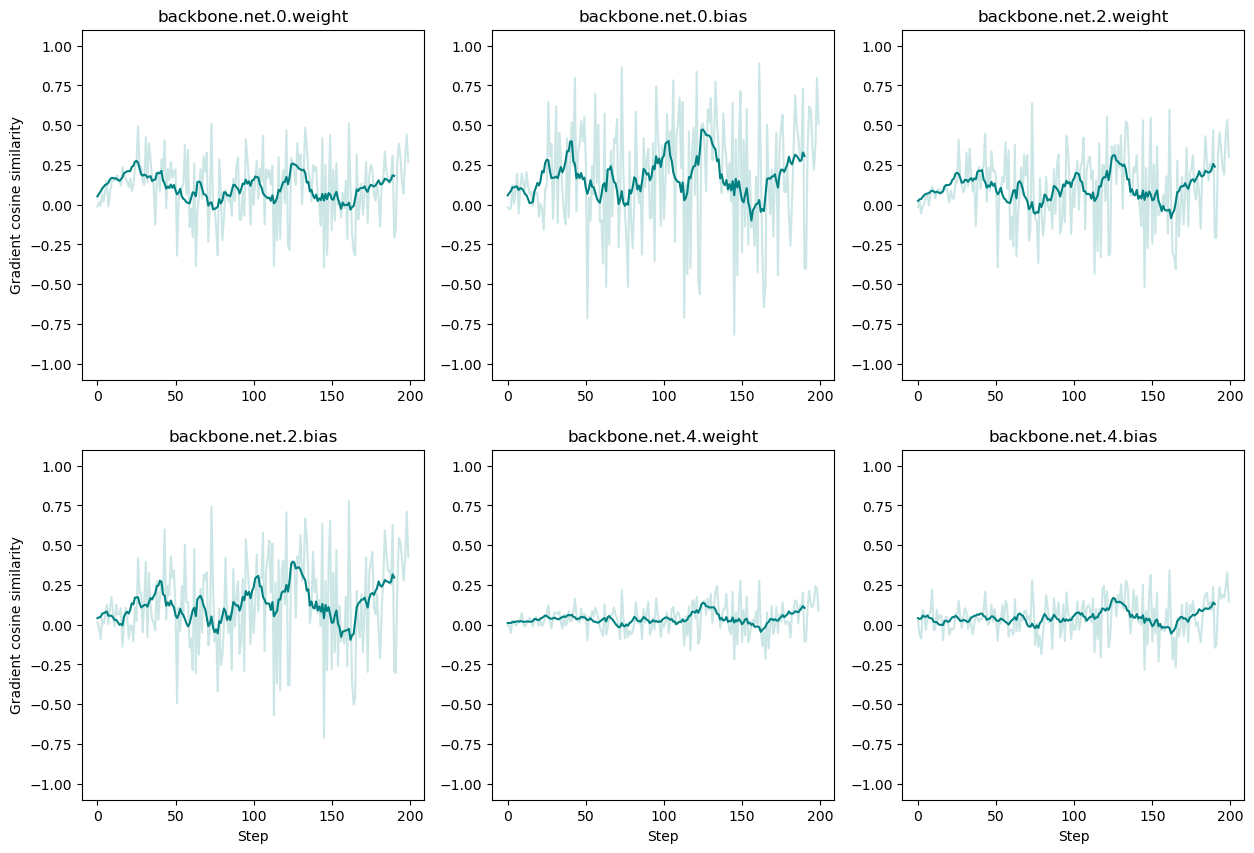

In [11]:
param_keys = ['backbone.' + k for k in list(shared_mtl.backbone.state_dict().keys())]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, key in enumerate(param_keys):
    # get gradients
    g0 = utils.stack_grad(grads, 'mnist', key)
    g1 = utils.stack_grad(grads, 'mnist_n', key)
    
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = utils.low_pass_filter(cosine[None], filter_size=10)[0][0]
    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 'std_cos': std_cos}
      
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')

In [12]:
heuristic_results

{'backbone.net.0.weight': {'avg_cos': 0.11006053, 'std_cos': tensor(0.1894)},
 'backbone.net.0.bias': {'avg_cos': 0.170862, 'std_cos': tensor(0.3477)},
 'backbone.net.2.weight': {'avg_cos': 0.1054449, 'std_cos': tensor(0.2213)},
 'backbone.net.2.bias': {'avg_cos': 0.12840308, 'std_cos': tensor(0.2806)},
 'backbone.net.4.weight': {'avg_cos': 0.03717359, 'std_cos': tensor(0.0887)},
 'backbone.net.4.bias': {'avg_cos': 0.045363832, 'std_cos': tensor(0.1141)}}

## Experiments

In [13]:
mtl = SharedMTL(tasks.keys())
fully_shared_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.29it/s]


In [14]:
class SeparateMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbones = nn.ModuleDict({
            task: model.LinearBackbone()
            for task in task_keys
        })
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbones[task](x)) 

mtl = SeparateMTL(tasks.keys())
separate_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.12it/s]


In [25]:
class SurgicalMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.Shareable(
            mdl=model.LinearBackbone(),
            task_keys=list(task_keys),
            shared_params=['net.0.weight', 'net.0.bias', 'net.0.weight', 'net.2.bias']
        )
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 10)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x, task))

mtl = SurgicalMTL(tasks.keys())
surgical_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.77it/s]


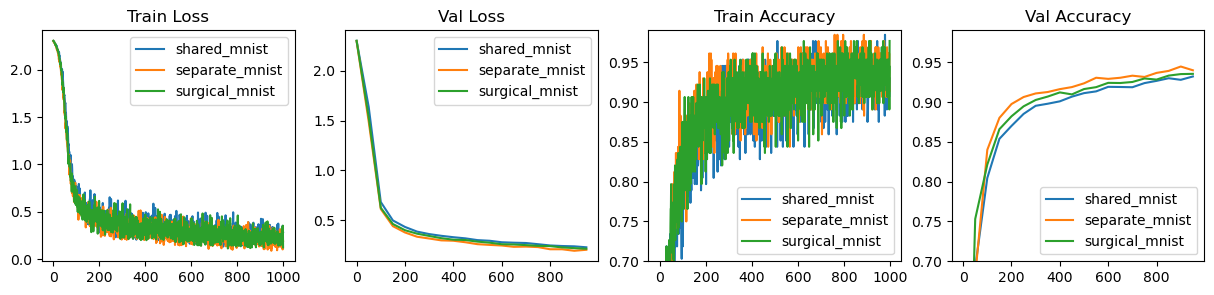

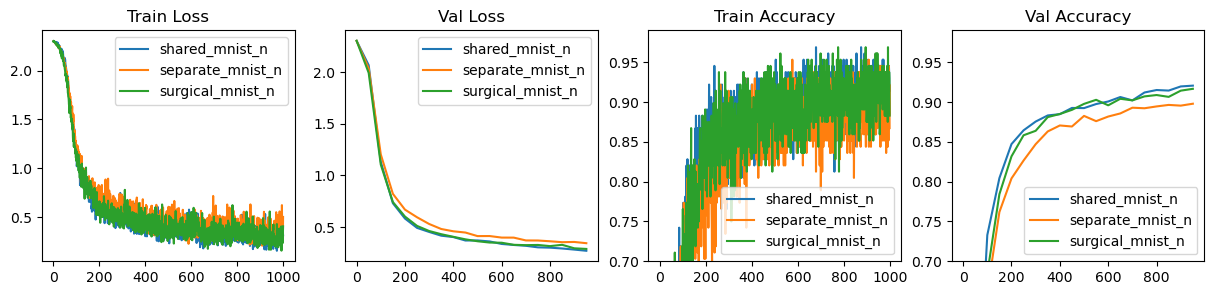

In [26]:
for task_name in tasks:
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        # plot
        ax = axes[0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[2]
        tm_x, tm_y = zip(*tm)
        ax.plot(tm_x, tm_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Accuracy')
        ax.set_ylim([0.7, 0.99])
        ax.legend()

        ax = axes[3]
        em_x, em_y = zip(*em)
        ax.plot(em_x, em_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Accuracy')
        ax.set_ylim([0.7, 0.99])
        ax.legend()